In [1]:
import numpy as np                        
import scipy.stats                        
import pylab as plt  
import emcee
import corner

Read the npy file

In [2]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/transient.npy'
data = np.load(input_file_path)

#print(data)

This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon:
- The first column is time (arbitrary units)
- the second column is the flux (arbitrary units)
- the third column are homoescedastic measurement uncertainties on the flux

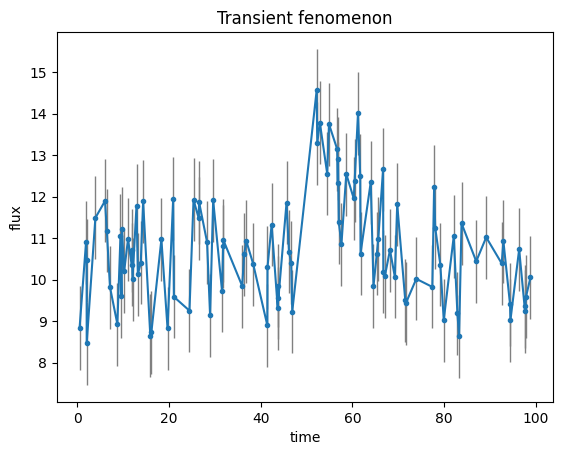

In [3]:
t,y,yerr=data.T

plt.errorbar(t,y,yerr=yerr, marker = '.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')

plt.show()

## I use **emcee** to perform a bayesian analysis

Using the tutorial: https://emcee.readthedocs.io/en/stable/tutorials/line/

### Setup

The model

- b = background amplitude
- A = burst amplitude
- t0 = burst epoch
- $\beta$ = how rapidly the burst dies off

In [4]:
def burst_model(x, theta):
    A, b, t0, alpha = theta
    result = b + A * np.exp(-alpha * (x - t0))
    result[x < t0] = b
    return result

The log likelihood

In [5]:
def LogLikelihood(theta, data, model):
    x, y, sigma_y = data.T
    y_model = model(x, theta)
    return -0.5 * np.sum((y-y_model)**2 / sigma_y**2 ) 

The log prior

In [6]:
Amin, Amax = 0, 50
bmin, bmax = 0, 50
t0min, t0max = 0, 100
alphamin, alphamax = np.exp(-5), np.exp(5)

def Logprior(theta):
    A,b,t0,alpha=theta
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return - np.log(alpha)    # 0.0 + 0.0 + 0.0 - np.log(alpha) --> since uniform in log alpha, so p(alpha) = 1/alpha
    else:
        return -np.inf   

The log posterior

In [7]:
def LogPosterior(theta, data, model):
    return LogLikelihood(theta, data, model) + Logprior(theta)

# The posterior in emcee is always something proportional to the actual posterior, since we are neglecting the evidence 

### Estimate the initial parameters using the maximum likelihood estimation

I first try to estimate reasonable parameters visually

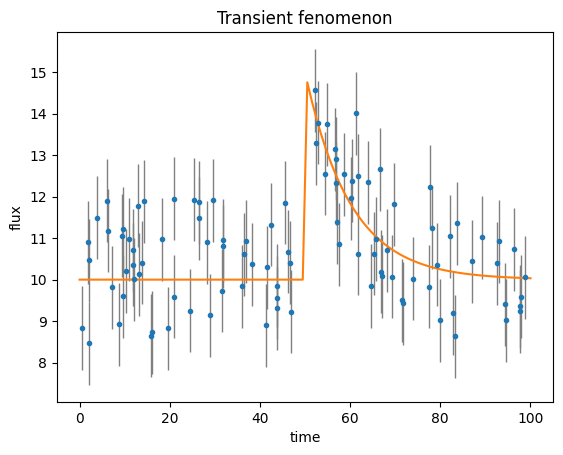

In [8]:
tgrid=np.linspace(0,100,100)
A_0=5
b_0=10
t0_0=50
alpha_0=0.1


theta_0 = np.array([A_0,b_0,t0_0,alpha_0])
ygrid = burst_model(tgrid,theta_0)

plt.errorbar(t,y,yerr=yerr, fmt='.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')
plt.plot(tgrid,ygrid);

### MCMC (emcee)

In [9]:
ndim = 4             # n of parameters
nwalkers = 20        # n of MCMC walkers
nsteps = 10000       # n of MCMC steps for each walker

starting_guesses = theta_0 + 0.05 * np.random.randn(nwalkers, ndim)

# sample the posterior
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[data, burst_model])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3156.42it/s]


State([[ 5.52016118 10.17717347 47.21765841  0.09227191]
 [ 5.07306714 10.34563319 48.3802124   0.1032031 ]
 [ 6.01734454  9.98345865 47.18873524  0.08508137]
 [ 5.94618806 10.21006093 47.43943827  0.09046376]
 [ 3.55970208 10.36798388 51.88139897  0.11021948]
 [ 6.08061094 10.25057475 49.76491271  0.14189651]
 [ 6.03974038 10.13438541 48.61105794  0.1117074 ]
 [ 3.50512422 10.34737066 51.66723143  0.11262029]
 [ 6.63182319 10.11557678 48.41001545  0.10405677]
 [ 4.56068751 10.46677088 50.01141242  0.12206537]
 [ 4.96327499 10.33222338 51.4464176   0.14538545]
 [ 4.35241167 10.38471834 51.35448579  0.11978062]
 [ 4.57780159 10.34957941 50.42494905  0.08677174]
 [ 3.08910332 10.252008   51.80674331  0.09741917]
 [ 3.15251997 10.29878768 51.81982839  0.10914622]
 [ 4.02181789 10.26312568 51.60479485  0.12611291]
 [ 4.17854565 10.50647859 51.61170129  0.1561643 ]
 [ 5.63912537 10.3285693  47.79792111  0.12529181]
 [ 2.79548284 10.3312075  50.65782085  0.10294677]
 [ 5.07939405 10.40288513

Visualize the chains

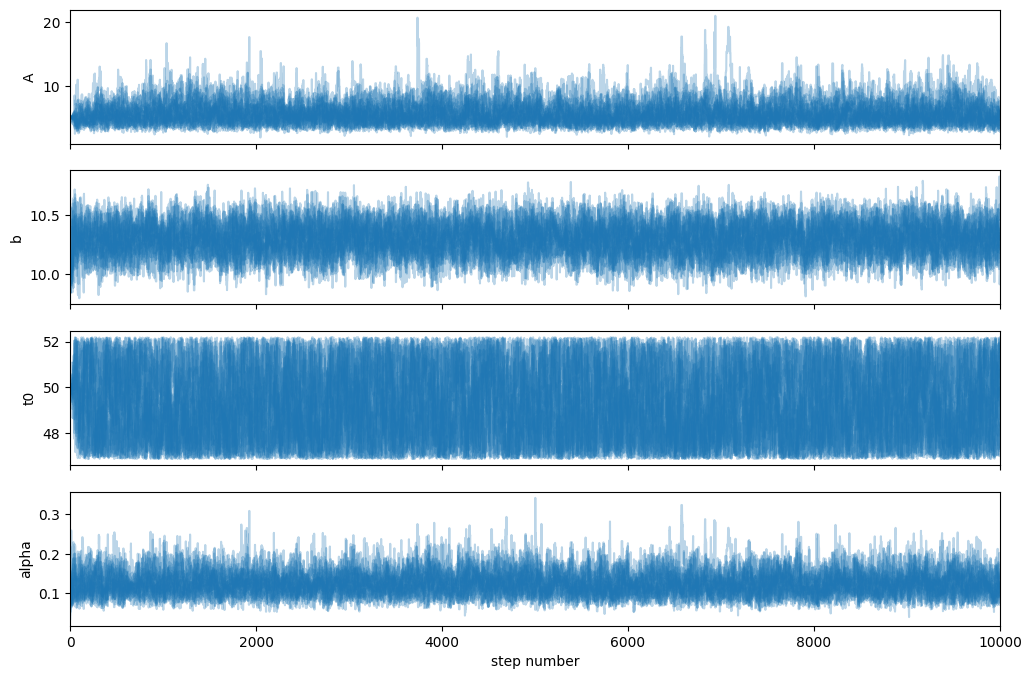

In [10]:
fig, axes = plt.subplots(4, figsize=(12, 8), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "C0", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, len(samples))

axes[-1].set_xlabel("step number");

Burn-in and thin the chain, using autocorrelation length

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[71.65089587 60.40773112 83.47107982 56.50060361]


In [12]:
thin_samples = sampler.get_chain(discard=4*int(max(tau)), thin=int(max(tau)), flat=True)
print(thin_samples.shape)

(2320, 4)


### Corner plots

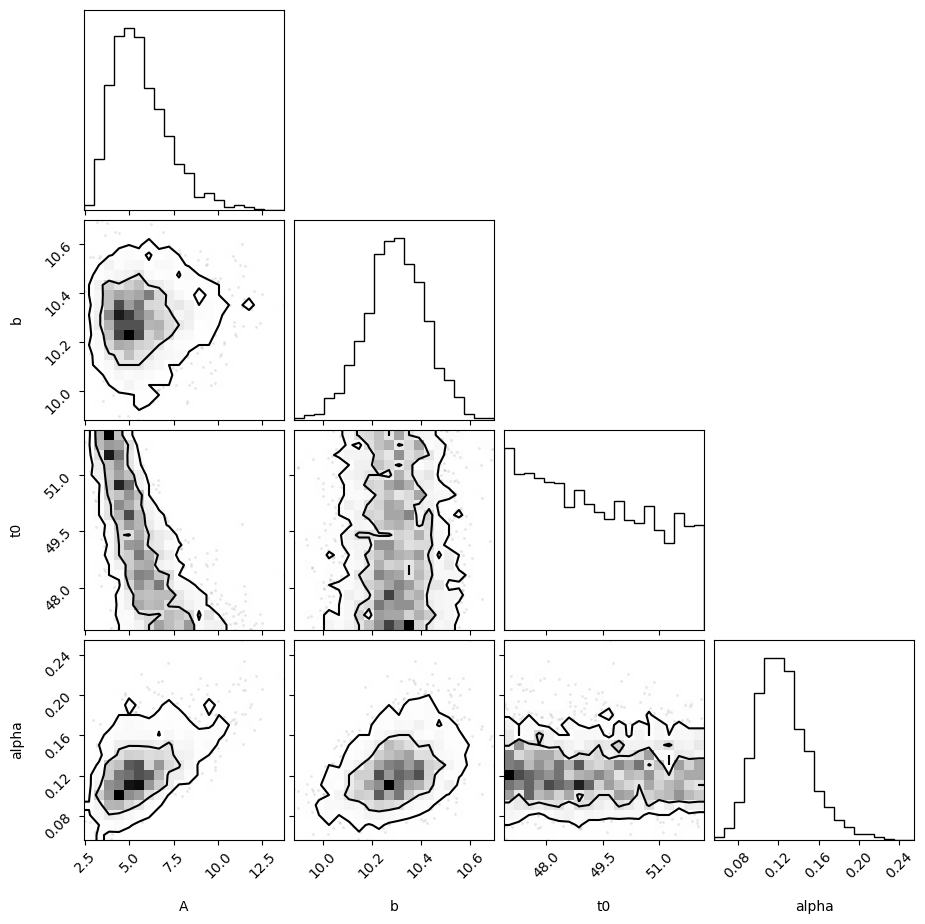

In [13]:
fig = corner.corner(thin_samples, labels=labels, levels=[0.68,0.95])

Choose $100$ samples randomly and plot the model

NB: each sample in my posterior is a possible realization (equally probable)

In [14]:
nsamples = 100
chosen_samples= thin_samples[np.random.choice(len(thin_samples),size=nsamples)]
print(chosen_samples.shape)

(100, 4)


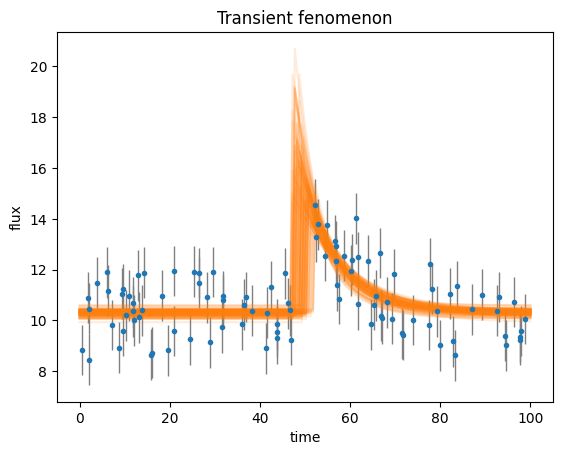

In [15]:
tgrid=np.linspace(0,100,200)

#plt.figure(figsize=(10,8))
plt.errorbar(t,y,yerr=yerr, fmt='.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')

for i in range(nsamples):
    plt.plot(tgrid, burst_model(tgrid, chosen_samples[i,:]), 'C1', alpha = 0.15)
plt.xlabel("time")
plt.ylabel("flux")

plt.show()

Median and quantiles

In [16]:
for i,l in enumerate(labels):
    low, med, up = np.percentile(thin_samples[:,i],[5,50,95]) 
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))

A   5.364636935043126 +3.215938497365748 -1.784199700831497
b   10.296177297885754 +0.20386755476386575 -0.202402270305436
t0   49.15373905796052 +2.6910741987155333 -2.1031056821778407
alpha   0.12190238165697079 +0.049892399290170114 -0.0350017664807275


NB: this is not my best model (not ok to use summary statistics to describe my data) --> a model with these parameters doesn't exist in my posterior chain. These are the medians of the marginalized (over one parameter at a time) distrbution.

If you need an estimator you could pick the model that maximizes the posterior 